In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers as kl
from tensorflow.keras import regularizers as kr
from tensorflow.keras import models as km
from tensorflow.keras import backend as K
from sklearn import preprocessing
from sklearn.decomposition import PCA
import scanpy as sc

In [2]:
# read in the scanpy object which was saved from scRNA_practice.ipynb
save_file = '/Users/xly/Desktop/study/python/scRNA_practice/autoencoder/adata_combat.h5ad'
adata_combat = sc.read_h5ad(save_file)

# use the raw data which is before batch correction
X = adata_combat.raw.X
X.shape

(3114, 12818)

## Variational autoencoder

In [3]:
# VAE
input_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 2

class Sampling(kl.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = kl.Input(shape=(input_dim,))
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim)(x)
z_log_var = kl.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = km.Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(input_dim, activation='relu')(x)
decoder = km.Model(latent_inputs, outputs, name='decoder')

# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= input_dim
            
            ### kl_loss can be referred to Eqn(7) in the reference 'Tutorial on Variational Autoencoders'
            kl_loss = - 0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return { 
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [4]:
opt = keras.optimizers.Adam()
vae = VAE(encoder, decoder)
vae.compile(optimizer=opt)

vae.fit(X, X, epochs=500, batch_size=32,shuffle=True)

Epoch 1/500
98/98 [==============================] - 2s 20ms/step - loss: 1373.1093 - reconstruction_loss: 1337.0515 - kl_loss: 36.0578
Epoch 2/500
98/98 [==============================] - 2s 16ms/step - loss: 1217.3347 - reconstruction_loss: 1201.2050 - kl_loss: 16.1296
Epoch 3/500
98/98 [==============================] - 2s 15ms/step - loss: 1191.7867 - reconstruction_loss: 1180.0105 - kl_loss: 11.7762
Epoch 4/500
98/98 [==============================] - 1s 15ms/step - loss: 1171.3108 - reconstruction_loss: 1161.7909 - kl_loss: 9.5200
Epoch 5/500
98/98 [==============================] - 1s 15ms/step - loss: 1163.0039 - reconstruction_loss: 1154.7298 - kl_loss: 8.2741
Epoch 6/500
98/98 [==============================] - 1s 15ms/step - loss: 1154.2653 - reconstruction_loss: 1146.8143 - kl_loss: 7.4510
Epoch 7/500
98/98 [==============================] - 1s 15ms/step - loss: 1146.6079 - reconstruction_loss: 1139.6147 - kl_loss: 6.9932
Epoch 8/500
98/98 [==============================] -

98/98 [==============================] - 1s 14ms/step - loss: 1065.4632 - reconstruction_loss: 1062.1388 - kl_loss: 3.3244
Epoch 62/500
98/98 [==============================] - 1s 14ms/step - loss: 1063.3811 - reconstruction_loss: 1060.0950 - kl_loss: 3.2861
Epoch 63/500
98/98 [==============================] - 1s 14ms/step - loss: 1065.6269 - reconstruction_loss: 1062.3519 - kl_loss: 3.2750
Epoch 64/500
98/98 [==============================] - 1s 14ms/step - loss: 1062.9790 - reconstruction_loss: 1059.6857 - kl_loss: 3.2933
Epoch 65/500
98/98 [==============================] - 1s 14ms/step - loss: 1062.4383 - reconstruction_loss: 1059.1543 - kl_loss: 3.2840
Epoch 66/500
98/98 [==============================] - 1s 14ms/step - loss: 1062.8430 - reconstruction_loss: 1059.5841 - kl_loss: 3.2588
Epoch 67/500
98/98 [==============================] - 1s 14ms/step - loss: 1062.1473 - reconstruction_loss: 1058.8670 - kl_loss: 3.2803
Epoch 68/500
98/98 [==============================] - 1s 14ms

98/98 [==============================] - 2s 21ms/step - loss: 1047.6216 - reconstruction_loss: 1044.3611 - kl_loss: 3.2605
Epoch 122/500
98/98 [==============================] - 1s 14ms/step - loss: 1048.9378 - reconstruction_loss: 1045.6756 - kl_loss: 3.2622
Epoch 123/500
98/98 [==============================] - 1s 15ms/step - loss: 1047.8550 - reconstruction_loss: 1044.5941 - kl_loss: 3.2609
Epoch 124/500
98/98 [==============================] - 2s 24ms/step - loss: 1047.1934 - reconstruction_loss: 1043.9232 - kl_loss: 3.2701
Epoch 125/500
98/98 [==============================] - 1s 15ms/step - loss: 1047.3643 - reconstruction_loss: 1044.1095 - kl_loss: 3.2548
Epoch 126/500
98/98 [==============================] - 2s 16ms/step - loss: 1047.6443 - reconstruction_loss: 1044.3682 - kl_loss: 3.2760
Epoch 127/500
98/98 [==============================] - 2s 16ms/step - loss: 1046.7698 - reconstruction_loss: 1043.4811 - kl_loss: 3.2887
Epoch 128/500
98/98 [==============================] - 

98/98 [==============================] - 1s 14ms/step - loss: 1037.0641 - reconstruction_loss: 1033.7088 - kl_loss: 3.3554
Epoch 181/500
98/98 [==============================] - 1s 14ms/step - loss: 1037.5499 - reconstruction_loss: 1034.1855 - kl_loss: 3.3644
Epoch 182/500
98/98 [==============================] - 1s 14ms/step - loss: 1039.6033 - reconstruction_loss: 1036.2352 - kl_loss: 3.3681
Epoch 183/500
98/98 [==============================] - 1s 14ms/step - loss: 1039.0348 - reconstruction_loss: 1035.6696 - kl_loss: 3.3651
Epoch 184/500
98/98 [==============================] - 1s 14ms/step - loss: 1036.8743 - reconstruction_loss: 1033.5170 - kl_loss: 3.3573
Epoch 185/500
98/98 [==============================] - 1s 14ms/step - loss: 1035.5717 - reconstruction_loss: 1032.2017 - kl_loss: 3.3700
Epoch 186/500
98/98 [==============================] - 1s 13ms/step - loss: 1036.9028 - reconstruction_loss: 1033.5335 - kl_loss: 3.3693
Epoch 187/500
98/98 [==============================] - 

98/98 [==============================] - 1s 14ms/step - loss: 1030.2237 - reconstruction_loss: 1026.8023 - kl_loss: 3.4214
Epoch 240/500
98/98 [==============================] - 1s 14ms/step - loss: 1031.8866 - reconstruction_loss: 1028.4888 - kl_loss: 3.3978
Epoch 241/500
98/98 [==============================] - 1s 14ms/step - loss: 1032.8313 - reconstruction_loss: 1029.4167 - kl_loss: 3.4146
Epoch 242/500
98/98 [==============================] - 1s 14ms/step - loss: 1034.4977 - reconstruction_loss: 1031.0716 - kl_loss: 3.4261
Epoch 243/500
98/98 [==============================] - 1s 13ms/step - loss: 1034.3807 - reconstruction_loss: 1030.9544 - kl_loss: 3.4263
Epoch 244/500
98/98 [==============================] - 1s 14ms/step - loss: 1032.0880 - reconstruction_loss: 1028.6765 - kl_loss: 3.4115
Epoch 245/500
98/98 [==============================] - 1s 13ms/step - loss: 1033.2133 - reconstruction_loss: 1029.7964 - kl_loss: 3.4168
Epoch 246/500
98/98 [==============================] - 

98/98 [==============================] - 1s 14ms/step - loss: 1028.6112 - reconstruction_loss: 1025.1858 - kl_loss: 3.4254
Epoch 299/500
98/98 [==============================] - 1s 14ms/step - loss: 1030.0115 - reconstruction_loss: 1026.5730 - kl_loss: 3.4384
Epoch 300/500
98/98 [==============================] - 1s 14ms/step - loss: 1027.5048 - reconstruction_loss: 1024.0604 - kl_loss: 3.4444
Epoch 301/500
98/98 [==============================] - 1s 14ms/step - loss: 1029.9152 - reconstruction_loss: 1026.4635 - kl_loss: 3.4517
Epoch 302/500
98/98 [==============================] - 1s 15ms/step - loss: 1030.0308 - reconstruction_loss: 1026.5603 - kl_loss: 3.4704
Epoch 303/500
98/98 [==============================] - 1s 14ms/step - loss: 1028.4768 - reconstruction_loss: 1025.0225 - kl_loss: 3.4543
Epoch 304/500
98/98 [==============================] - 1s 13ms/step - loss: 1028.3756 - reconstruction_loss: 1024.9320 - kl_loss: 3.4436
Epoch 305/500
98/98 [==============================] - 

98/98 [==============================] - 1s 14ms/step - loss: 1020.0165 - reconstruction_loss: 1016.5178 - kl_loss: 3.4986
Epoch 358/500
98/98 [==============================] - 1s 14ms/step - loss: 1017.6891 - reconstruction_loss: 1014.2176 - kl_loss: 3.4715
Epoch 359/500
98/98 [==============================] - 1s 14ms/step - loss: 1019.8500 - reconstruction_loss: 1016.3385 - kl_loss: 3.5115
Epoch 360/500
98/98 [==============================] - 1s 14ms/step - loss: 1018.1768 - reconstruction_loss: 1014.6786 - kl_loss: 3.4982
Epoch 361/500
98/98 [==============================] - 1s 14ms/step - loss: 1020.8436 - reconstruction_loss: 1017.3662 - kl_loss: 3.4773
Epoch 362/500
98/98 [==============================] - 1s 13ms/step - loss: 1018.4129 - reconstruction_loss: 1014.8901 - kl_loss: 3.5228
Epoch 363/500
98/98 [==============================] - 1s 14ms/step - loss: 1019.1063 - reconstruction_loss: 1015.6269 - kl_loss: 3.4794
Epoch 364/500
98/98 [==============================] - 

98/98 [==============================] - 1s 14ms/step - loss: 1017.5869 - reconstruction_loss: 1014.0682 - kl_loss: 3.5187
Epoch 417/500
98/98 [==============================] - 1s 14ms/step - loss: 1017.3574 - reconstruction_loss: 1013.8126 - kl_loss: 3.5448
Epoch 418/500
98/98 [==============================] - 1s 14ms/step - loss: 1020.2502 - reconstruction_loss: 1016.7380 - kl_loss: 3.5123
Epoch 419/500
98/98 [==============================] - 1s 14ms/step - loss: 1019.0931 - reconstruction_loss: 1015.5638 - kl_loss: 3.5293
Epoch 420/500
98/98 [==============================] - 1s 14ms/step - loss: 1015.7592 - reconstruction_loss: 1012.2539 - kl_loss: 3.5053
Epoch 421/500
98/98 [==============================] - 1s 14ms/step - loss: 1015.8030 - reconstruction_loss: 1012.2925 - kl_loss: 3.5105
Epoch 422/500
98/98 [==============================] - 1s 14ms/step - loss: 1018.3463 - reconstruction_loss: 1014.8414 - kl_loss: 3.5049
Epoch 423/500
98/98 [==============================] - 

98/98 [==============================] - 1s 13ms/step - loss: 1018.2975 - reconstruction_loss: 1014.7376 - kl_loss: 3.5599
Epoch 476/500
98/98 [==============================] - 1s 13ms/step - loss: 1016.2102 - reconstruction_loss: 1012.6457 - kl_loss: 3.5645
Epoch 477/500
98/98 [==============================] - 1s 14ms/step - loss: 1015.9107 - reconstruction_loss: 1012.3827 - kl_loss: 3.5279
Epoch 478/500
98/98 [==============================] - 1s 14ms/step - loss: 1018.0643 - reconstruction_loss: 1014.5451 - kl_loss: 3.5192
Epoch 479/500
98/98 [==============================] - 1s 14ms/step - loss: 1015.1676 - reconstruction_loss: 1011.6242 - kl_loss: 3.5434
Epoch 480/500
98/98 [==============================] - 1s 14ms/step - loss: 1015.2449 - reconstruction_loss: 1011.6990 - kl_loss: 3.5460
Epoch 481/500
98/98 [==============================] - 1s 14ms/step - loss: 1017.1376 - reconstruction_loss: 1013.5740 - kl_loss: 3.5636
Epoch 482/500
98/98 [==============================] - 

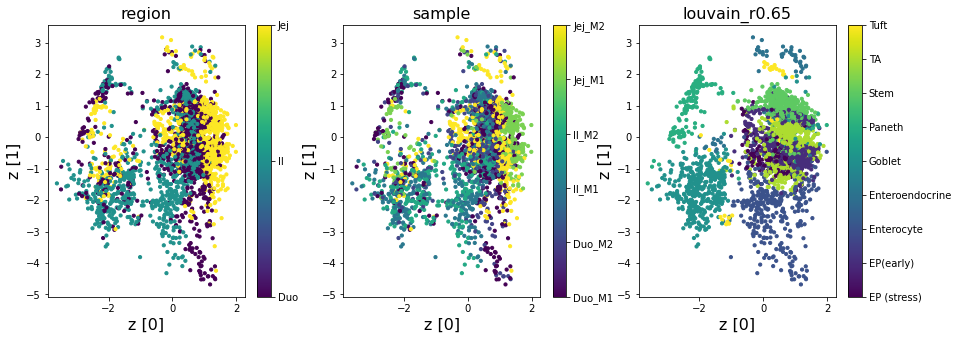

In [5]:
# Plot the latent space the dim of which is 2.
le = preprocessing.LabelEncoder()
x_encoded = encoder.predict(X)[2]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, obs in zip([0, 1, 2], ['region', 'sample', 'louvain_r0.65']):
    le.fit(list(adata_combat.obs[obs]))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    color = le.transform(adata_combat.obs[obs])    
    im = axes[i].scatter(x_encoded[:, 0], x_encoded[:, 1], c=color, marker='o', s=10)
    axes[i].set_xlabel('z [0]', fontsize='16')
    axes[i].set_ylabel('z [1]', fontsize='16')
    axes[i].set_title(obs, fontsize='16')
    cb = plt.colorbar(im, ax=axes[i])
    loc = np.arange(max(color) + 1)
    cb.set_ticks(loc)
    cb.set_ticklabels(list(le_name_mapping.keys()))

Different clusters in "louvain_r0.65" separate from each other more or less, but the boundaries appear not very clear. Interestingly, "Tuft" cells do not aggregate in one group. There is still space to improve the model (e.g. adding more hidden layers).

## Autoencoder
As a comparison, an autoencoder model is trained below.

In [6]:
# Encoder
inputs = kl.Input(shape=(input_dim,))
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
z = kl.Dense(latent_dim)(x)
encoder = km.Model(inputs, z, name='encoder')

# Decoder
latent_inputs = kl.Input(shape=(latent_dim,))
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(input_dim, activation='relu')(x)
decoder = km.Model(latent_inputs, outputs, name='decoder')
    
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

In [7]:
opt = keras.optimizers.Adam()
ae = AE(encoder, decoder)
ae.compile(optimizer=opt, loss='mse', experimental_run_tf_function=False)

ae.fit(X, X, epochs=500, batch_size=32, shuffle=True)

Epoch 1/500
98/98 [==============================] - 2s 19ms/step - loss: 0.1146
Epoch 2/500
98/98 [==============================] - 1s 15ms/step - loss: 0.1017
Epoch 3/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0964
Epoch 4/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0941
Epoch 5/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0926
Epoch 6/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0920
Epoch 7/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0912
Epoch 8/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0906
Epoch 9/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0904
Epoch 10/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0899
Epoch 11/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0893
Epoch 12/500
98/98 [==============================] - 1s 15ms/step - loss: 0.0890
Epoch 13/500
98/98 [=====

98/98 [==============================] - 1s 13ms/step - loss: 0.0765
Epoch 102/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0765
Epoch 103/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0764
Epoch 104/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0764
Epoch 105/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0763
Epoch 106/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0763
Epoch 107/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0763
Epoch 108/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0762
Epoch 109/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0762
Epoch 110/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0762
Epoch 111/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0762
Epoch 112/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0762
Epoch 113/500
98/9

98/98 [==============================] - 2s 25ms/step - loss: 0.0746
Epoch 200/500
98/98 [==============================] - 2s 20ms/step - loss: 0.0745
Epoch 201/500
98/98 [==============================] - 1s 15ms/step - loss: 0.0745
Epoch 202/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 203/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 204/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0746
Epoch 205/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 206/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 207/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 208/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 209/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 210/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0745
Epoch 211/500
98/9

98/98 [==============================] - 1s 13ms/step - loss: 0.0739
Epoch 298/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0739
Epoch 299/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0739
Epoch 300/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 301/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 302/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 303/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 304/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 305/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 306/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 307/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0738
Epoch 308/500
98/98 [==============================] - 2s 16ms/step - loss: 0.0738
Epoch 309/500
98/9

98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 396/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 397/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 398/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 399/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 400/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 401/500
98/98 [==============================] - 1s 14ms/step - loss: 0.0732
Epoch 402/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 403/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 404/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 405/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 406/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0732
Epoch 407/500
98/9

98/98 [==============================] - 1s 13ms/step - loss: 0.0729
Epoch 494/500
98/98 [==============================] - 1s 15ms/step - loss: 0.0729
Epoch 495/500
98/98 [==============================] - 2s 16ms/step - loss: 0.0729
Epoch 496/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0729
Epoch 497/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0729
Epoch 498/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0729
Epoch 499/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0729
Epoch 500/500
98/98 [==============================] - 1s 13ms/step - loss: 0.0729


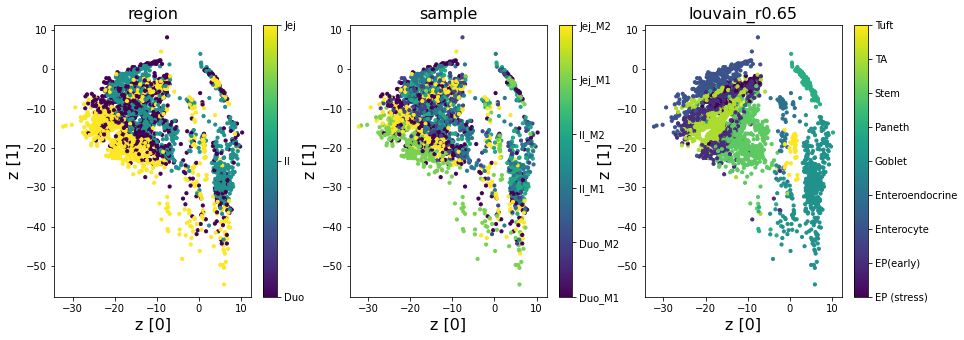

In [8]:
le = preprocessing.LabelEncoder()
x_encoded = encoder.predict(X)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, obs in zip([0, 1, 2], ['region', 'sample', 'louvain_r0.65']):
    le.fit(list(adata_combat.obs[obs]))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    color = le.transform(adata_combat.obs[obs])
    im = axes[i].scatter(x_encoded[:, 0], x_encoded[:, 1], c=color, marker='o', s=10)
    axes[i].set_xlabel('z [0]', fontsize='16')
    axes[i].set_ylabel('z [1]', fontsize='16')
    axes[i].set_title(obs, fontsize='16')
    cb = plt.colorbar(im, ax=axes[i])
    loc = np.arange(max(color) + 1)
    cb.set_ticks(loc)
    cb.set_ticklabels(list(le_name_mapping.keys()))

Using autoencoder, some clusters in "louvain_r0.65" lie on diagonal lines more obviously. Probably the autoencoder learns an approximation of PCA, although it is not quite the same (see PCA below as a comparison).

## PCA

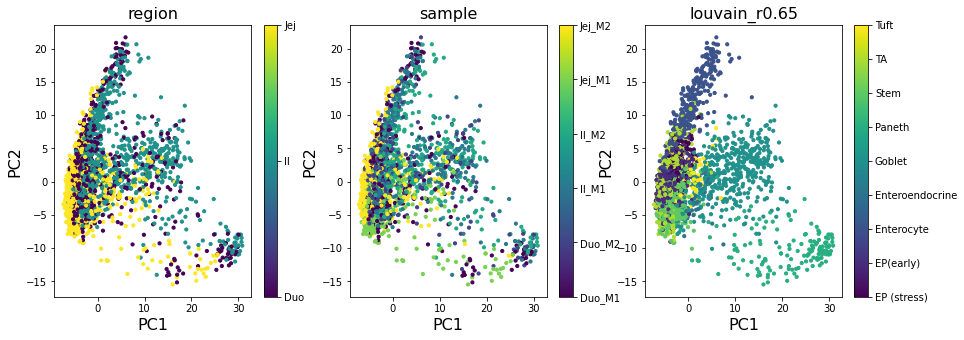

In [12]:
# PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, obs in zip([0, 1, 2], ['region', 'sample', 'louvain_r0.65']):
    le.fit(list(adata_combat.obs[obs]))
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    color = le.transform(adata_combat.obs[obs])
    im = axes[i].scatter(pc[:, 0], pc[:, 1], c=color, marker='o', s=10)
    axes[i].set_xlabel('PC1', fontsize='16')
    axes[i].set_ylabel('PC2', fontsize='16')
    axes[i].set_title(obs, fontsize='16')
    cb = plt.colorbar(im, ax=axes[i])
    loc = np.arange(max(color) + 1)
    cb.set_ticks(loc)
    cb.set_ticklabels(list(le_name_mapping.keys()))